In [1]:
import pandas as pd
import numpy as np
import spamcheck
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import string
from googletrans import Translator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
%matplotlib inline

In [4]:
# Loading data

follower_data =  pd.read_csv(r"./Datasets/#LawyersVsDelhiPolice_follower_followee_network.csv", encoding="utf-8")
tweet_data = pd.read_csv(r"./Datasets/#LawyersVsDelhiPolice_tweets.csv", encoding="utf-8")

### Follower - Follower ratio

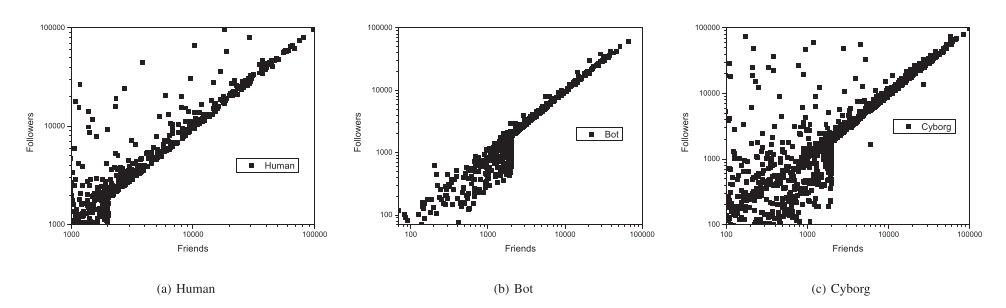

Chu, Zi & Gianvecchio, Steven & Wang, Haining & Jajodia, Sushil. (2012). Detecting Automation of Twitter Accounts: Are You a Human, Bot, or Cyborg?. Dependable and Secure Computing, IEEE Transactions on. 9. 811-824. 10.1109/TDSC.2012.75. 




Bots tend to follow a lot of people hoping that someone would follow them back. Since following back is considered kind of an etique in twitter. 

With twitter taking measures to identify bots using this feature, advances started keeping this ratio close to 1 (Unfollow if one doesnt follow back in a fixed amount of time). But they overdo it. Even though the ratio is closer to 1, typically they follow a ridiculously large number of people which is not common in the case of a human.

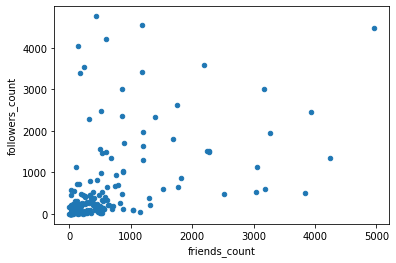

In [9]:
follower_data.loc[follower_data.followers_count < 5000].plot(kind = "scatter", x = "friends_count", y = "followers_count")

Clearly the above graph looks like the mix of all three graphs from the study cited above. Now, we seperate the users who lie in the extreme areas. Which are to the bottom right (old fasion bots) and top right (advanced bots).

Text(0.5, 1.0, 'Goof follower followee ratio, but following too many')

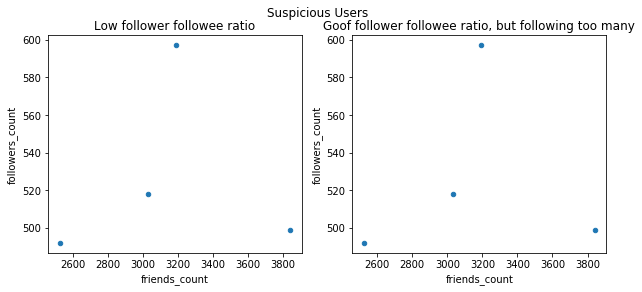

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
fig.suptitle('Suspicious Users')
follower_data.loc[np.logical_and((follower_data.followers_count < 1000).values, (follower_data.friends_count > 2000).values)].plot(kind = "scatter", x = "friends_count", y = "followers_count", ax = ax1)
follower_data.loc[np.logical_and((follower_data.followers_count < 1000).values, (follower_data.friends_count > 2000).values)].plot(kind = "scatter", x = "friends_count", y = "followers_count", ax = ax2)
ax1.set_title("Low follower followee ratio")
ax2.set_title("Good follower followee ratio, but following too many")

In [21]:
suspicious_user_ids = follower_data.loc[np.logical_and((follower_data.followers_count < 1000).values, (follower_data.friends_count > 3000).values)]["user_id"]
suspicious_user_ids = suspicious_user_ids.append(follower_data.loc[np.logical_and((follower_data.followers_count > 2500).values, (follower_data.friends_count > 2500).values)]["user_id"])
print("Suspicious user ids")
suspicious_user_ids

Suspicious user ids


8              4167378493
48              155519301
199             155519301
30             3057929443
42     753991296386203652
Name: user_id, dtype: int64

We need more evidence. We cood look at the tweets, but since only 6 minutes worth of tweets were available, its better to focus on other metadata related features. There are many features that can be used to identify bots from profile metadata.

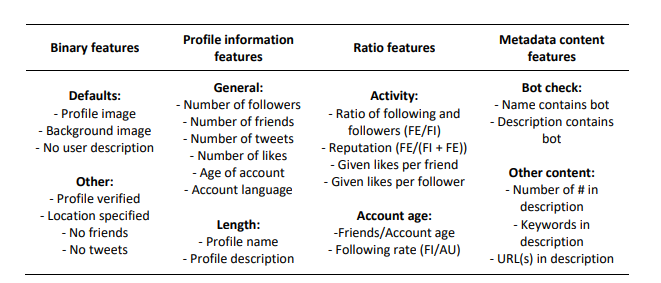
DETECTING AND ANALYZING BOTS ON FINNISH POLITICAL TWITTER, Sippo Rossi Aalto University 

But we dont have much info, none of the above seem to give more information than we already have in out case.

### Tweet Frequency
Bots have a high tweet frequency. Look at the graph that we have made in Question 1. The graph shows the retweet network in first two minutes..

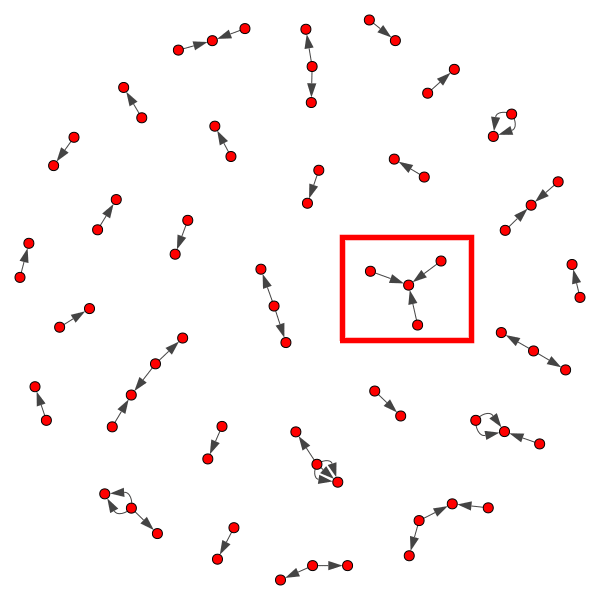
This account seems to have retweeted three tweets from three different accounts but having similar content in under 2 minutes. Looking at the suspicious ids from before, we have a match!

In [24]:
follower_data.loc[follower_data.user_id == 4167378493]

,account_created_at,followerIDs,followers_count,friendIDs,friends_count,id,location,name,screen_name,user_id,verified
8,2015-11-08 10:47:42,"1004782123046170624, 828964335938596866, 11902...",499,"1063059712386592768, 831370208392548352, 83106...",3840,9,"Dhenkanal, Odisha",Pankaj Kumar Nayak,PankajDKL,4167378493,False


Looking at the tweets, in 2 min, this person has retweeted hate speech against amit shaw from three different sources whom he doesnt follow. We have a BOT.

In [27]:
tweet_data.loc[tweet_data.user_id == "x" + str(4167378493)].text

11    Amit shah sitting at home and reading comment ...
12    Amit Shah sitting at Dharna. \n\nIn Ahamadabad...
13    Tis Hazari court case: Delhi Police protests, ...
Name: text, dtype: object

A similar measure is reputation. It is defined as 
reputation = followercount / (follower count + friends count)
Reputation is 1 for a celibrity, around 0.5 for normal users and low (close to 0) for a bot.

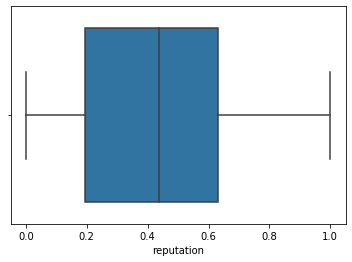

In [28]:
#median at 0.5. Expected since most are normal users.
follower_data["reputation"] = follower_data["followers_count"] / (follower_data["followers_count"] + follower_data["friends_count"])
sns.boxplot(follower_data["reputation"])

## #AmazonFires
Since this network has a big enough retweet graph over enough time, we can look into network related features.
#### Frequency


In [31]:
follower_data = pd.read_csv(r"./Datasets/#AmazonFires_follower_followee_network.csv", encoding="utf-8")
tweet_data = pd.read_csv(r"./Datasets/#AmazonFires_tweets.csv", encoding="utf-8")

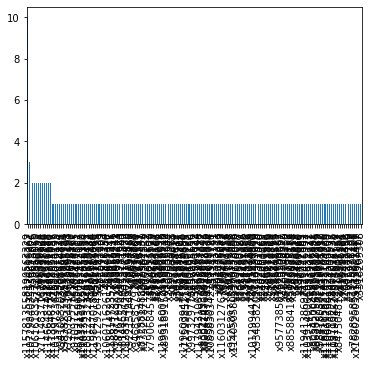

In [37]:
uids = tweet_data["user_id"]
unique_uids = uids.unique()
follower_data['user_id'] = unique_uids
follower_data["frequency"] = tweet_data.user_id.value_counts()[follower_data.user_id].values
tweet_data.user_id.value_counts().plot(kind = "bar")

Not many tweets with high frequency. Looking at the high frequency ones.

In [39]:
follower_data.loc[follower_data.frequency>2]

,id,screen_name,followerIDs,friendIDs,followers_count,friends_count,name,location,account_created_at,verified,user_id,frequency
51,52,GPShoreditch,"844593198, 839140950261788678, 719114697937707...","65065882, 1848089072, 856148305, 17463923, 192...",538,309,Greenpeace Shoreditch,"Shoreditch, London",2014-03-05 18:56:15,False,x2374216267,3
125,126,arne_matthew,"741623192083521536, 300017145, 978751530600927...","741623192083521536, 1006419421244678144, 24518...",214,136,Matt - Creative Director,NaN,2019-08-04 00:40:38,False,x1157813558190563329,10


In [42]:
tweet_data.loc[tweet_data.user_id == "x1157813558190563329"]

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
136,x1157813558190563329,x1197739175656574976,2019-11-22 04:50:47,arne_matthew,in stock now! portion of all proceeds will be ...,Twitter Web App,140,NaN,NaN,NaN,...,638,251,2019-08-04 00:40:38,False,https://t.co/ZIEGPOaipn,http://antisocialbohemian.com,NaN,https://pbs.twimg.com/profile_banners/11578135...,NaN,http://pbs.twimg.com/profile_images/1157813684...
137,x1157813558190563329,x1197739042789453825,2019-11-22 04:50:15,arne_matthew,https://t.co/g4dQwGCbxI portion of all proceed...,Twitter Web App,140,NaN,NaN,NaN,...,638,251,2019-08-04 00:40:38,False,https://t.co/ZIEGPOaipn,http://antisocialbohemian.com,NaN,https://pbs.twimg.com/profile_banners/11578135...,NaN,http://pbs.twimg.com/profile_images/1157813684...
138,x1157813558190563329,x1197738969020035072,2019-11-22 04:49:57,arne_matthew,https://t.co/khjTY2n4E1 &lt;&lt;&lt; portion o...,Twitter Web App,149,NaN,NaN,NaN,...,638,251,2019-08-04 00:40:38,False,https://t.co/ZIEGPOaipn,http://antisocialbohemian.com,NaN,https://pbs.twimg.com/profile_banners/11578135...,NaN,http://pbs.twimg.com/profile_images/1157813684...
139,x1157813558190563329,x1197739148691427329,2019-11-22 04:50:40,arne_matthew,portion of all proceeds goes directly to fire ...,Twitter Web App,140,NaN,NaN,NaN,...,638,251,2019-08-04 00:40:38,False,https://t.co/ZIEGPOaipn,http://antisocialbohemian.com,NaN,https://pbs.twimg.com/profile_banners/11578135...,NaN,http://pbs.twimg.com/profile_images/1157813684...
140,x1157813558190563329,x1197739055259082753,2019-11-22 04:50:18,arne_matthew,https://t.co/W2E1L6q4du portion of all proceed...,Twitter Web App,140,NaN,NaN,NaN,...,638,251,2019-08-04 00:40:38,False,https://t.co/ZIEGPOaipn,http://antisocialbohemian.com,NaN,https://pbs.twimg.com/profile_banners/11578135...,NaN,http://pbs.twimg.com/profile_images/1157813684...
141,x1157813558190563329,x1197738849411055617,2019-11-22 04:49:29,arne_matthew,https://t.co/00e1GRgwGz &lt;&lt;&lt; Save the ...,Twitter Web App,149,NaN,NaN,NaN,...,638,251,2019-08-04 00:40:38,False,https://t.co/ZIEGPOaipn,http://antisocialbohemian.com,NaN,https://pbs.twimg.com/profile_banners/11578135...,NaN,http://pbs.twimg.com/profile_images/1157813684...
142,x1157813558190563329,x1197738787201114114,2019-11-22 04:49:14,arne_matthew,https://t.co/BLX3wkWoql &lt;&lt;&lt; portion o...,Twitter Web App,149,NaN,NaN,NaN,...,638,251,2019-08-04 00:40:38,False,https://t.co/ZIEGPOaipn,http://antisocialbohemian.com,NaN,https://pbs.twimg.com/profile_banners/11578135...,NaN,http://pbs.twimg.com/profile_images/1157813684...
143,x1157813558190563329,x1197738704032256000,2019-11-22 04:48:54,arne_matthew,in stock now! portion of all proceeds will be ...,Twitter Web App,149,NaN,NaN,NaN,...,638,251,2019-08-04 00:40:38,False,https://t.co/ZIEGPOaipn,http://antisocialbohemian.com,NaN,https://pbs.twimg.com/profile_banners/11578135...,NaN,http://pbs.twimg.com/profile_images/1157813684...
144,x1157813558190563329,x1197738883837882368,2019-11-22 04:49:37,arne_matthew,https://t.co/QP9QbSBRrl &lt;&lt;&lt; portion o...,Twitter Web App,149,NaN,NaN,NaN,...,638,251,2019-08-04 00:40:38,False,https://t.co/ZIEGPOaipn,http://antisocialbohemian.com,NaN,https://pbs.twimg.com/profile_banners/11578135...,NaN,http://pbs.twimg.com/profile_images/1157813684...
145,x1157813558190563329,x1197738941920636929,2019-11-22 04:49:51,arne_matthew,https://t.co/z9z08110GJ &lt;&lt;&lt; Save the ...,Twitter Web App,149,NaN,NaN,NaN,...,638,251,2019-08-04 00:40:38,False,https://t.co/ZIEGPOaipn,http://antisocialbohemian.com,NaN,https://pbs.twimg.com/profile_banners/11578135...,NaN,http://pbs.twimg.com/profile_images/1157813684...


All the tweets are made in very short period. Looking at the profile, we find these two are bots. One is for a volunteer group and the other one is for a merchandise selling website.
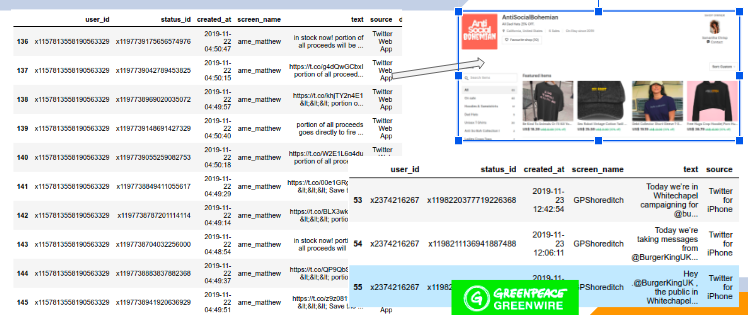

In [43]:
result = spamcheck.check("in stock now! portion of all proceeds will be directly donated to fire abatement efforts: https://t.co/52SKL75h1r #amazonia #amazonfire #amazonforest #prayforamazonia #brazil #amazonfires #forestfires #rainforest #savetherainforest #earthday https://t.co/QYVdWgzIZ1'", report=True)
result

{'success': True,
 'score': '7.9',
 'rules': [{'score': '1.2', 'description': 'Missing To: header'},
  {'score': '-0.0',
   'description': 'Informational: message was not relayed via SMTP'},
  {'score': '1.4', 'description': 'Missing Date: header'},
  {'score': '0.1', 'description': 'Missing Message-Id: header'},
  {'score': '2.3',
   'description': 'Message appears to have no textual parts and no Subject: text'},
  {'score': '-0.0',
   'description': 'Informational: message has no Received headers'},
  {'score': '1.8', 'description': 'Missing Subject: header'},
  {'score': '1.0', 'description': 'Missing From: header'},
  {'score': '0.0',
   'description': 'Message appears to be missing most RFC-822 headers'}],
 'report': ' pts rule                   description                                       \n---- ---------------------- --------------------------------------------------\n 1.2 MISSING_HEADERS        Missing To: header                                \n-0.0 NO_RELAYS             

#### Spam check not working as expected since its built for emails.

### Other network related features
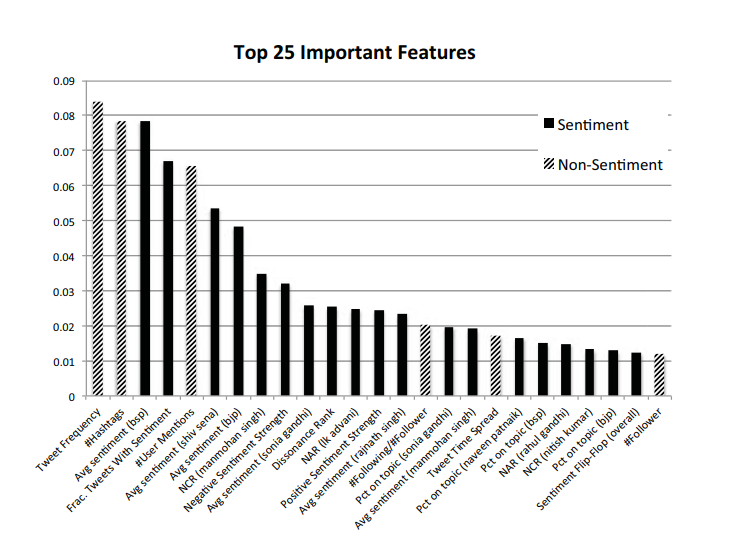
J. P. Dickerson, V. Kagan and V. S. Subrahmanian, "Using sentiment to detect bots on Twitter: Are humans more opinionated than bots?," 2014 IEEE/ACM International Conference on Advances in Social Networks Analysis and Mining (ASONAM 2014), Beijing, 2014, pp. 620-627.

Clearly, sentiment related features play an important rolefrom the above graph representing top features that have been recognised for detecting bots. 

One of the important and useful measure is rate of change of sentiment. We extract sentiment for the tweets. Similar as in Question 2.

In [44]:
translate_urls = ["translate.google.com", "translate.google.co.kr",
                      "translate.google.at", "translate.google.de",
                      "translate.google.ru", "translate.google.ch",
                      "translate.google.fr", "translate.google.es"]
translator = Translator(service_urls=translate_urls)
def extract_emojis(str):
    return ''.join(c for c in str if c not in emoji.UNICODE_EMOJI)

tweet_data.sort_values(by=['user_id', 'created_at'])
txt_mat=dict()
for j in tweet_data.user_id.unique():
    txt_mat[j]=[]

translator = Translator()
for index,i in tweet_data.iterrows():
    
    txt_mat[i["user_id"]].append(translator.translate(extract_emojis(i['text'].translate(str.maketrans('', '', string.punctuation))),dest='en').text)
    
def sentiment_scores(sentences): 
    sentis = []
    for sentence in sentences : 
        sid_obj = SentimentIntensityAnalyzer() 
        sentiment_dict = sid_obj.polarity_scores(sentence) 
        sentis.append(sentiment_dict['compound'])
    return sentis
follower_data["sentiments"] = follower_data.user_id.apply(lambda x : sentiment_scores(txt_mat[x]))

In [46]:
follower_data.loc[follower_data.frequency>=2]

,id,screen_name,followerIDs,friendIDs,followers_count,friends_count,name,location,account_created_at,verified,user_id,frequency,sentiments
11,12,FilipeEco,"43775694, 35847805, 1176205717876797440, 99385...","2149418172, 35847805, 189172530, 80588528, 231...",559,967,Filipe França,NaN,2009-12-21 15:09:32,False,x98399324,2,"[0.0, 0.6124]"
41,42,Dragofix,"1079814096625623041, 1095812209496768512, 1187...","854974257226502144, 3281352691, 895007629, 864...",3527,4989,Dragofix,Finland,2009-07-20 22:31:24,False,x58613026,2,"[0.1779, 0.1779]"
51,52,GPShoreditch,"844593198, 839140950261788678, 719114697937707...","65065882, 1848089072, 856148305, 17463923, 192...",538,309,Greenpeace Shoreditch,"Shoreditch, London",2014-03-05 18:56:15,False,x2374216267,3,"[-0.25, -0.2263, -0.128]"
53,54,suedashbell,"205237628, 539004138, 4882743003, 584750787, 2...","205237628, 3574875675, 78361556, 2910961127, 1...",27,87,Sue Bell,"London, England",2013-07-25 08:27:36,False,x1619798946,2,"[-0.128, -0.128]"
54,55,NO2USPLUTOCRACY,"24702789, 1186063758432620549, 192715700, 1121...","24702789, 192715700, 1075244237275480064, 1131...",2116,2037,👀🐝 CLIMATE WARRIOR # 1 Bernie 2020 or DEATH,NaN,2015-06-06 11:29:34,False,x3310426131,2,"[-0.7717, -0.34]"
58,59,scally_ray,"989628378, 109654333, 382826939, 30589555, 816...","1684230956, 1188505570149588992, 2700568116, 1...",1277,399,Ray Scally,"Disley, Cheshire. - ex Dublin",2016-03-20 09:25:11,False,x711483716791635968,2,"[0.0, 0.6124]"
60,61,Alexander_Lees,"1323030684, 815235815441731585, 57249937, 1188...","2471225112, 972540235, 3742194027, 2814511846,...",3489,1136,Alex Lees,"Manchester, England",2016-01-01 13:15:31,False,x4689372030,2,"[0.6124, 0.0]"
62,63,Winningare1,"3489303862, 1164221449722355712, 9060700604265...","224126124, 1196778982886297610, 11876164575359...",13621,3982,🏆🥇WINNING 🥇🥇ARENA 💯💯🇳🇬🇳🇬🇳🇬🇳🇬🇳🇬🏁,"Lagos, Nigeria",2018-12-12 22:38:23,False,x1072984035536891904,2,"[0.799, 0.799]"
76,77,NO_PLANETB_,"1151940365718609920, 1120186334, 1197960108594...","2733199069, 1678934198, 226856497, 2695527631,...",170,95,THERE IS NO PLANET B,"Luebeck, Germany",2018-11-11 13:55:15,False,x1061618357722669060,2,"[0.0, -0.4404]"
95,96,AmazonWatch,"798212152641261568, 80047208, 1191336780412465...","704470681665216512, 299320161, 231923667, 9641...",79317,3669,AMAZON WATCH,"Oakland, California",2009-03-05 20:15:00,True,x22971125,2,"[0.09, -0.0798]"


Upon further investigation, most of the users with suspicious sentiment (Monotonic) turned out to be bots.


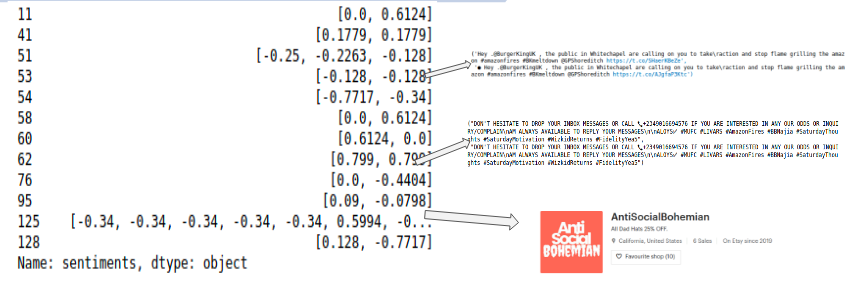


Although we are unable to find any bots that are trying to influence in AmazonFires, we have found a good number of bots. Bots swawing public opinion might not be a characteristic of this network given the kind of topic it deals with.

#### Note - We have tried other methods like network related methods, community related methods etc and also many other computations to arrive at the results above. We have omitted them for brevity and have summarized our work in this notebook.